In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

import astropy.stats
from   astropy.io import fits as pyfits
import csv
import sys
import os
import glob
from   timeit import default_timer as timer
import warnings
import corner

from chainconsumer import ChainConsumer

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from alderaan.constants import *
from alderaan.utils import weighted_percentile
from alderaan.utils import bin_data
import alderaan.io as io

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K01426-02"
PRIMARY_DIR = '/Users/research/projects/alderaan/'

if MISSION == "Simulated":
    CSV_FILE = PRIMARY_DIR + "Catalogs/simulated_catalog.csv"
    TRUE_TTV_DIR = PRIMARY_DIR + "Simulations/TTVs/"
    
if MISSION == "Kepler":
    CSV_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"

In [3]:
PLANET_NO = int(TARGET[-2:])
KOI_ID = TARGET[:6]

TARGET, KOI_ID, PLANET_NO

('K01426-02', 'K01426', 2)

In [4]:
UPSAMPLE = 10
ECC_SCALE = 0.008

# Make sure the necessary paths exist

In [5]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + KOI_ID + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + KOI_ID + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + KOI_ID + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + KOI_ID + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + KOI_ID + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in independently determined stellar parameters

In [6]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    KOI_ID = KOI_ID
    
elif MISSION == 'Simulated':
    KOI_ID = "K" + KOI_ID[1:]

else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")
    
    
# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['koi_id']) == KOI_ID

KIC = np.array(target_dict['kic_id'], dtype='int')[use]
NPL = np.array(target_dict['npl'], dtype='int')[use]

RSTAR_TRUE = np.array(target_dict['rstar'],  dtype='float')[use]

LOGRHO_TRUE = np.array(target_dict['logrho'], dtype='float')[use]
LOGRHO_ERR1_TRUE = np.array(target_dict['logrho_err1'], dtype='float')[use]
LOGRHO_ERR2_TRUE = np.array(target_dict['logrho_err2'], dtype='float')[use]

U1_TRUE = np.array(target_dict['limbdark_1'], dtype='float')[use]
U2_TRUE = np.array(target_dict['limbdark_2'], dtype='float')[use]

Reading in data from csv file


In [7]:
PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

PERIODS = np.array(target_dict['period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

In [8]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR_TRUE[0] for r in RSTAR_TRUE): RSTAR_TRUE = RSTAR_TRUE[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == LOGRHO_TRUE[0] for r in LOGRHO_TRUE): LOGRHO_TRUE = LOGRHO_TRUE[0]
else: raise ValueError('There are inconsistencies with LOGRHO in the csv input file')

if all(r == LOGRHO_ERR1_TRUE[0] for r in LOGRHO_ERR1_TRUE): LOGRHO_ERR1_TRUE = LOGRHO_ERR1_TRUE[0]
else: raise ValueError('There are inconsistencies with LOGRHO_ERR1 in the csv input file')

if all(r == LOGRHO_ERR2_TRUE[0] for r in LOGRHO_ERR2_TRUE): LOGRHO_ERR2_TRUE = LOGRHO_ERR2_TRUE[0]
else: raise ValueError('There are inconsistencies with LOGRHO_ERR2 in the csv input file')

if all(u == U1_TRUE[0] for u in U1_TRUE): U1_TRUE = U1_TRUE[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2_TRUE[0] for u in U2_TRUE): U2_TRUE = U2_TRUE[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

In [9]:
RHO_TRUE = 10**(LOGRHO_TRUE)
RHO_ERR1_TRUE = 10**(LOGRHO_TRUE + LOGRHO_ERR1_TRUE) - RHO_TRUE
RHO_ERR2_TRUE = 10**(LOGRHO_TRUE + LOGRHO_ERR2_TRUE) - RHO_TRUE
RHO_ERR_TRUE  = np.sqrt(RHO_ERR1_TRUE**2 + RHO_ERR2_TRUE**2)/np.sqrt(2)

RHO_OBS = (RHO_TRUE, RHO_ERR_TRUE)

# Pull trace posteriors

Data structure is traces[$umbrella$][$parameter$], e.g. traces["G"]["LOG_R"]

In [10]:
trace_files = np.sort(glob.glob(TRACE_DIR + KOI_ID + "_{:02d}_shape_*".format(PLANET_NO)))

with pyfits.open(trace_files[0]) as trace:
    print(trace.info())

Filename: /Users/research/projects/alderaan/Traces/K01426/K01426_02_shape_C.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  LOG_DUR       1 ImageHDU         7   (30000,)   float64   
  2  C0            1 ImageHDU         7   (30000,)   float64   
  3  C1            1 ImageHDU         7   (30000,)   float64   
  4  FLUX0         1 ImageHDU         8   (10, 30000)   float64   
  5  LOGJIT        1 ImageHDU         8   (10, 30000)   float64   
  6  LOG_R         1 ImageHDU         7   (30000,)   float64   
  7  R             1 ImageHDU         7   (30000,)   float64   
  8  B             1 ImageHDU         7   (30000,)   float64   
  9  GAMMA         1 ImageHDU         7   (30000,)   float64   
 10  DUR           1 ImageHDU         7   (30000,)   float64   
 11  TTS           1 ImageHDU         8   (10, 30000)   float64   
 12  P             1 ImageHDU         7   (30000,)   float64   
 13  T0            1 ImageHDU

In [11]:
traces = {}

for i, tf in enumerate(trace_files):
    UID = tf[-6]
    
    traces[UID] = {}
    
    with pyfits.open(tf) as trace_data:
        
        for j in range(1,len(trace_data)):
            key = trace_data[j].header["EXTNAME"]
            
            traces[UID][key] = np.squeeze(trace_data[j].data)

# Check transition umbrella $\gamma$

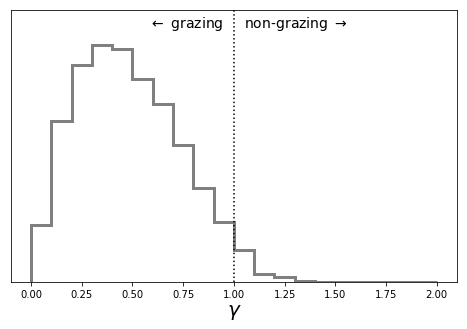

9721 out of 10000 samples are consistent with a grazing transit


In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
bins = np.linspace(0,2,21)

npl = PLANET_NO
g = traces["T"]["GAMMA"]

y, x, _ = ax.hist(g, bins=bins, density=True, histtype="step", color="grey".format(npl), lw=3)

ax.axvline(1, ls=":", color="k")
ax.text(0.95,y.max()*1.13, r"$\leftarrow$ grazing", va="top", ha="right", fontsize=14)
ax.text(1.05,y.max()*1.13, r"non-grazing $\rightarrow$", va="top", ha="left", fontsize=14)
ax.set_xlabel(r"$\gamma$", fontsize=20)
ax.set_ylim(0, y.max()*1.15)
ax.set_yticks([])

#plt.savefig("/Users/research/projects/grazing_transits/Figures/transition_umbrella_K01426-02.pdf", bbox_inches="tight")
plt.show()


num_G = np.sum(g < 1)
num_N = np.sum(g >= 1)

print("{0} out of {1} samples are consistent with a grazing transit".format(num_G, len(g)))

# Check for consistent $r$, $b$, $T$

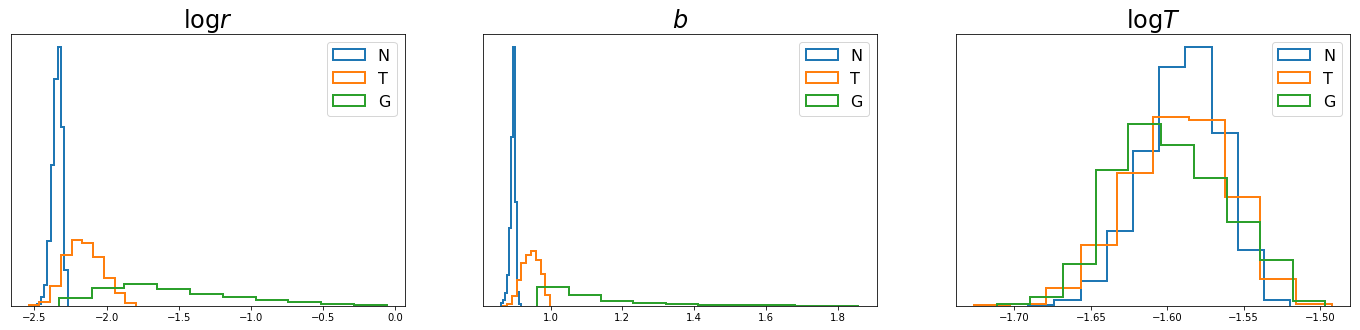

In [13]:
fig, ax = plt.subplots(1,3, figsize=(24,5))

if num_N > 0: ax[0].hist(traces["N"]["LOG_R"], histtype="step", density=True, lw=2, label="N")
ax[0].hist(traces["T"]["LOG_R"], histtype="step", density=True, lw=2, label="T")
if num_G > 0: ax[0].hist(traces["G"]["LOG_R"], histtype="step", density=True, lw=2, label="G")
ax[0].set_yticks([])
ax[0].legend(fontsize=16)
ax[0].set_title("$\log r$", fontsize=24)

if num_N > 0: ax[1].hist(traces["N"]["B"], histtype="step", density=True, lw=2, label="N")
ax[1].hist(traces["T"]["B"], histtype="step", density=True, lw=2, label="T")
if num_G > 0: ax[1].hist(traces["G"]["B"], histtype="step", density=True, lw=2, label="G")
ax[1].set_yticks([])
ax[1].legend(fontsize=16)
ax[1].set_title("$b$", fontsize=24)

if num_N > 0: ax[2].hist(traces["N"]["LOG_DUR"], histtype="step", density=True, lw=2, label="N")
ax[2].hist(traces["T"]["LOG_DUR"], histtype="step", density=True, lw=2, label="T")
if num_G > 0: ax[2].hist(traces["G"]["LOG_DUR"], histtype="step", density=True, lw=2, label="G")
ax[2].set_yticks([])
ax[2].legend(fontsize=16)
ax[2].set_title("$\log T$", fontsize=24)

plt.show()

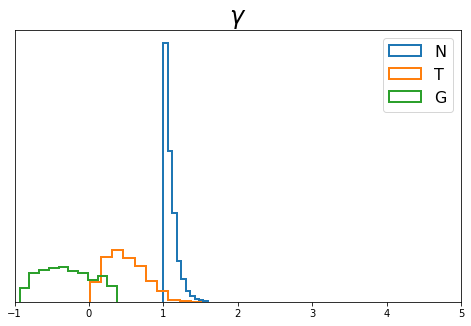

In [14]:
plt.figure(figsize=(8,5))

if num_N > 0: plt.hist(traces["N"]["GAMMA"], histtype="step", density=True, lw=2, label="N")
plt.hist(traces["T"]["GAMMA"], histtype="step", density=True, lw=2, label="T")
if num_G > 0: plt.hist(traces["G"]["GAMMA"], histtype="step", density=True, lw=2, label="G")
plt.xlim(-1,5)
plt.yticks([])
plt.legend(fontsize=16)
plt.title("$\gamma$", fontsize=24)
plt.show()

# Define umbrella functions

In [15]:
rmin, rmax = 1e-4, 0.99

def psi_N(x, norm=1/rmin-1.5):
    x_ = np.atleast_1d(x)
    
    psi = np.zeros_like(x_)
    psi[(x_ < 2)*(x_ >= 1)] = x_[(x_ < 2)*(x_ >= 1)] - 1
    psi[(x_ >= 2)] = 1.0
    psi = psi.clip(0,1)
    
    return psi/norm


def psi_T(x, norm=1.0):
    x_ = np.atleast_1d(x)
    psi = np.zeros_like(x_)
    psi[(x_ >= 0)*(x_ < 1)] = x_[(x_ >= 0)*(x_ < 1)]
    psi[(x_ >= 1)*(x_ < 2)] = 2 - x_[(x_ >= 1)*(x_ < 2)]
    psi = psi.clip(0,1)
    
    return psi/norm

    
def psi_G(x, norm=1.5):
    x_ = np.atleast_1d(x)
    
    psi = np.zeros_like(x_)
    psi[(x_ < 0)*(x_ >= -1)] = 1. + x_[(x_ < 0)*(x_ >= -1)]
    psi[(x_ >= 0)] = 1. - x_[x_ >= 0]
    psi = psi.clip(0,1)
    
    return psi/norm

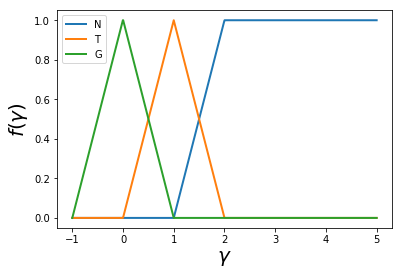

In [16]:
if (num_G > 0)*(num_N > 0):
    psi_fxns = [psi_N, psi_T, psi_G]
    psi_names = ["N", "T", "G"]
    
elif (num_G == 0)*(num_N > 0):
    psi_fxns = [psi_N, psi_T]
    psi_names = ["N", "T"]
    
elif (num_G > 0)*(num_nongrazN == 0):
    psi_fxns = [psi_T, psi_G]
    psi_names = ["T", "G"]    
    
Nwin = len(psi_fxns)

plt.figure()
x = np.linspace(-1, 5, 1000)
for i in range(Nwin):
    plt.plot(x, psi_fxns[i](x)/psi_fxns[i](x).max(), lw=2, label=psi_names[i])
plt.xlabel("$\gamma$", fontsize=20)
plt.ylabel("$f(\gamma)$", fontsize=20)
plt.legend()
plt.show()

# Post-hoc eccentricity weighting

In [17]:
weights_ecc = []

for i, name in enumerate(psi_names):
    rho_circ = np.repeat(traces[name]["RHO"], UPSAMPLE)
    
    if ECC_SCALE is None:
        ecc = np.random.uniform(0, 1, len(rho_circ))
        omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(rho_circ))
    
    else:
        esinw, ecosw = np.random.normal(loc=0, scale=ECC_SCALE, size=2*len(rho_circ)).reshape(2,-1)
        ecc = np.sqrt(esinw**2 + ecosw**2)
        omega = np.arctan2(esinw, ecosw)

        while np.any(ecc >= 1):
            print("redrawing", np.sum(ecc>=1))
            esinw, ecosw = np.random.normal(loc=0, scale=ECC_SCALE, size=2*np.sum(ecc>=1)).reshape(2,-1)
            omega[ecc>=1] = np.arctan2(esinw, ecosw)
            ecc[ecc>=1] = np.sqrt(esinw**2 + ecosw**2)
            
    # calculate weight from photoeccentric effect 
    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_circ / g ** 3

    log_weight = -0.5 * ((rho - RHO_OBS[0]) / RHO_OBS[1]) ** 2
    weight = np.exp(log_weight - np.max(log_weight))
    weight /= np.sum(weight)

    tol = 1e-12
    weight[weight < tol] = tol

    weights_ecc.append(weight/np.sum(weight))

# Calculate umbrella weights

In [18]:
from alderaan import emus
import importlib as imp

In [19]:
coords = []

for i, name in enumerate(psi_names):
    coords.append(np.repeat(traces[name]["GAMMA"], UPSAMPLE))

In [20]:
z = emus.umbrella_weights(psi_fxns, coords, weights_ecc)

weights_umb = []
for i in range(Nwin):
    wd = 0.
    for k in range(Nwin):
        wd += psi_fxns[k](coords[i])/z[k]
        
    weights_umb.append(1./wd)
    
weights = np.array(weights_umb).flatten()/np.sum(weights_umb) * np.hstack(weights_ecc)/np.sum(weights_ecc)
weights /= np.sum(weights)

In [21]:
psi_names

['N', 'T', 'G']

# Grab samples

In [22]:
var_keys = ["R", "B", "DUR", "P", "RHO"]
var_names = ["r", "b", "dur", "per", "rho"]

samples = {}

for i, key in enumerate(var_keys):
    name = var_names[i]
    samples[name] = []
    
    for i, psi in enumerate(psi_names):
        samples[name].append(np.repeat(traces[psi][key], UPSAMPLE))
        
    samples[name] = np.hstack(samples[name])
    

samples["u1"] = []
samples["u2"] = []
for i, psi in enumerate(psi_names):
    samples["u1"].append(np.repeat(traces[psi]["U"][:,0], UPSAMPLE))
    samples["u2"].append(np.repeat(traces[psi]["U"][:,1], UPSAMPLE))
    
samples["u1"] = np.hstack(samples["u1"])
samples["u2"] = np.hstack(samples["u2"])

# Basic statsitics

In [23]:
for var in var_names:
    x = []

    for q in [16, 50, 84, 95]:
        x.append(weighted_percentile(samples[var], q, weights))
        
    if var == "r":
        x = np.array(x)*RSTAR_TRUE*RSRE
    else:
        x = np.array(x)

    print("\n{0}".format(var))
    print("----")
    print("{0:.3f} +{1:.3f} -{2:.3f}".format(x[1], x[2]-x[1], x[1]-x[0]))
    print("{0:.2f} +/- {1:.2f}".format(x[1], (x[2]-x[0])/2))    
    print("{0:.2f} < {1:.2f}".format(x[1], x[3]))    



r
----
25.020 +21.911 -9.948
25.02 +/- 15.93
25.02 < 64.56

b
----
1.134 +0.243 -0.119
1.13 +/- 0.18
1.13 < 1.57

dur
----
0.201 +0.008 -0.006
0.20 +/- 0.01
0.20 < 0.21

per
----
150.022 +0.000 -0.000
150.02 +/- 0.00
150.02 < 150.02

rho
----
1.811 +0.241 -0.308
1.81 +/- 0.27
1.81 < 2.19


# Now plot the posterior lightcurve model

### Load detrended lightcurves

In [24]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + KOI_ID + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + KOI_ID + '_sc_detrended.fits')
except:
    sc = None

In [25]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
EPOCHS  = np.zeros(NPL)
PERIODS = np.zeros(NPL)

transit_inds = []
quick_transit_times = []
quick_ephemeris = []


for npl in range(NPL):
    # read in predetermined transit times
    fname_in = QUICK_TTV_DIR + KOI_ID + '_{:02d}'.format(npl) + '_quick.ttvs'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    quick_transit_times.append(data_in[:,2])
    
    # do a quick fit to get a linear ephemeris
    pfit = poly.polyfit(transit_inds[npl], quick_transit_times[npl], 1)
    
    quick_ephemeris.append(poly.polyval(transit_inds[npl], pfit))
    
    EPOCHS[npl] = pfit[1]
    PERIODS[npl] = pfit[0]
    
    
# make sure transit_inds are zero-indexed
for npl in range(NPL):
    transit_inds[npl] = np.array(transit_inds[npl] - transit_inds[npl][0], dtype="int")

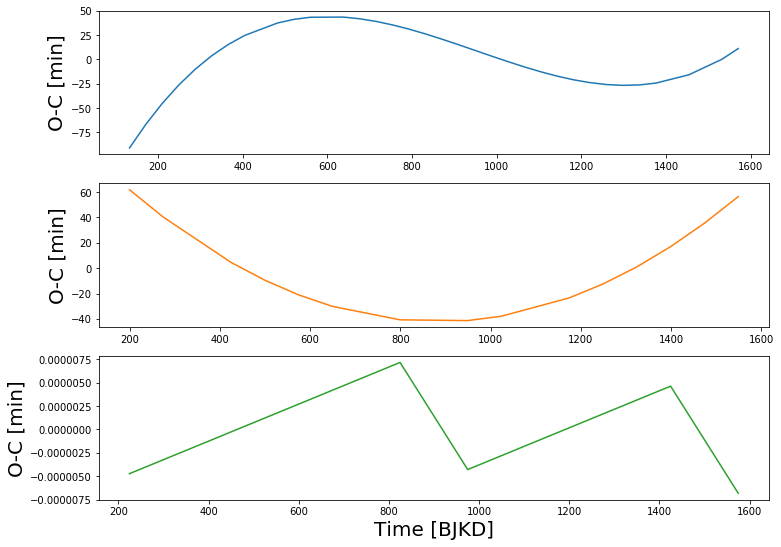

In [26]:
fig, ax = plt.subplots(NPL, figsize=(12,3*NPL))

if NPL == 1:
    ax = [ax]

for npl in range(NPL):
    xtime = quick_ephemeris[npl]
    yomc = (quick_transit_times[npl] - quick_ephemeris[npl])*24*60
    
    ax[npl].plot(xtime, yomc, '-', c='C{0}'.format(npl))
    ax[npl].set_ylabel('O-C [min]', fontsize=20)
ax[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

### Identify overlapping transits

In [27]:
if lc is not None:
    lc_quarters = np.unique(lc.quarter)
else:
    lc_quarters = np.array([])
    
if sc is not None:
    sc_quarters = np.unique(sc.quarter)
else:
    sc_quarters = np.array([])
    
    
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

In [28]:
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(quick_ephemeris[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in quick_ephemeris[j]:
                overlap[i] += np.abs(quick_ephemeris[i] - tt) < (DURS[i] + DURS[j] + lcit)

### Phase-folded the data

In [29]:
npl = PLANET_NO
tts = quick_transit_times[npl][~overlap[npl]]
dur = weighted_percentile(samples["dur"], 50, weights)

t_folded = []
f_folded = []

# grab the data
for t0 in tts:
    if sc is not None:
        use = np.abs(sc.time-t0)/dur < 1.5

        if np.sum(use) > 0:
            t_folded.append(sc.time[use]-t0)
            f_folded.append(sc.flux[use])

    if lc is not None:
        use = np.abs(lc.time-t0)/dur < 1.5

        if np.sum(use) > 0:
            t_folded.append(lc.time[use]-t0)
            f_folded.append(lc.flux[use])

# sort the data
t_folded = np.hstack(t_folded)
f_folded = np.hstack(f_folded)

order = np.argsort(t_folded)
t_folded = t_folded[order]
f_folded = f_folded[order]


# bin the data
t_binned, f_binned = bin_data(t_folded, f_folded, dur/11)

# set undersampling factor and plotting limits
inds = np.arange(len(t_folded), dtype="int")
inds = np.random.choice(inds, size=np.min([3000,len(inds)]), replace=False)

ymin = 1 - 5*np.std(f_folded)
ymax = 1 + 3*np.std(f_folded)

### Generate model lightcurve from posterior samples

In [30]:
import exoplanet as exo
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano

import pymc3 as pm

In [31]:
NDRAW = 50

draw = np.random.choice(np.arange(len(weights)), p=weights, size=NDRAW)
t_ = np.linspace(t_folded.min(), t_folded.max(), 250)
light_curves = [None]*NDRAW

u1 = theano.shared(samples["u1"][0], "u1")
u2 = theano.shared(samples["u2"][0], "u2")
r  = theano.shared(samples["r"][0], "r")
b  = theano.shared(samples["b"][0], "b")
per = theano.shared(samples["per"][0], "per")
dur = theano.shared(samples["dur"][0], "dur")


for i, d in enumerate(draw):
    print(i, d)
    
    u1.set_value(samples["u1"][d])
    u2.set_value(samples["u2"][d])
    r.set_value(samples["r"][d])
    b.set_value(samples["b"][d])
    per.set_value(samples["per"][d])
    dur.set_value(samples["dur"][d])
    
    starrystar = exo.LimbDarkLightCurve([u1,u2])
    orbit = exo.orbits.KeplerianOrbit(period = per, ror=r, b = b, duration =dur)
    
    light_curves[i] = starrystar.get_light_curve(orbit=orbit, r=r, t=t_, oversample=7).sum(-1).eval()

    
light_curves = np.array(light_curves)

0 254811
1 213081
2 232521
3 270323
4 207401
5 205899
6 256798
7 258738
8 272958
9 208402
10 228598
11 203826
12 250644
13 285403
14 248517
15 218075
16 233042
17 291544
18 214633
19 227227
20 211398
21 257738
22 233258
23 288663
24 266949
25 226880
26 270035
27 265126
28 268540
29 226523
30 245844
31 274283
32 277239
33 181774
34 238674
35 224286
36 203767
37 287858
38 217870
39 248573
40 259836
41 226366
42 205838
43 241223
44 283158
45 203849
46 215768
47 206112
48 286688
49 254988


### Plot the lightcurve

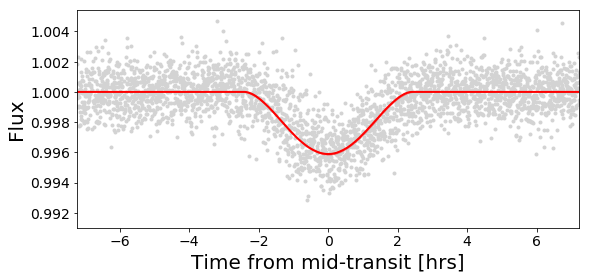

In [32]:
plt.figure(figsize=(9,4))

plt.plot(t_folded[inds]*24, f_folded[inds], ".", c="lightgrey", zorder=0)
plt.xlim(t_folded.min()*24, t_folded.max()*24)
plt.ylim(ymin, ymax)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time from mid-transit [hrs]", fontsize=20)
plt.ylabel("Flux", fontsize=20)

f_16 = 1+np.percentile(light_curves, 16, axis=0)
f_50 = 1+np.percentile(light_curves, 50, axis=0)
f_84 = 1+np.percentile(light_curves, 84, axis=0)

plt.plot(t_*24, f_50, c="red", lw=2)
plt.fill_between(t_*24, f_16, f_84, color="red", alpha=0.3)
plt.savefig(FIGURE_DIR + KOI_ID + '_{0:02d}_posterior_model.pdf'.format(npl), bbox_inches='tight')
plt.show()

# Corner plots

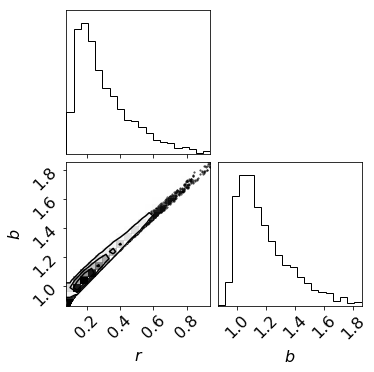

In [33]:
plt.rcParams.update({'font.size': 16})

data = np.array([samples["r"], samples["b"]])
labels = ["$r$", "$b$"]

fig = corner.corner(data.T, labels=labels, weights=weights);

#plt.savefig(FIGURE_DIR + KOI_ID + '_{0:02d}_rb_posteriors.pdf'.format(npl), bbox_inches='tight')